In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from pathlib import Path

# 设置字体为Times New Roman
plt.rcParams['font.family'] = 'Arial'

# 读取可行性分析结果数据
data_path = Path("../result/island_viability_summary_electric.csv")
df = pd.read_csv(data_path)

# 显示数据概况
print(f"数据形状: {df.shape}")
print(f"情景列表: {df['scenario'].unique()}")
print(f"Viability gap统计:")
print(df['viability_gap'].describe())

数据形状: (10980, 16)
情景列表: ['output_0' 'output_2020' 'output_2050' 'output_future_2030'
 'output_future_2040' 'output_future_2050']
Viability gap统计:
count    10980.000000
mean        -0.425257
std          0.739480
min         -4.148942
25%         -1.006200
50%          0.043717
75%          0.082420
max          0.954005
Name: viability_gap, dtype: float64


正在为岛屿分配IPCC区域...
将进行以下情景对比: [('output_0', 'output_2020'), ('output_0', 'output_2050')]

--- 正在处理对比: output_0 vs output_2020 ---


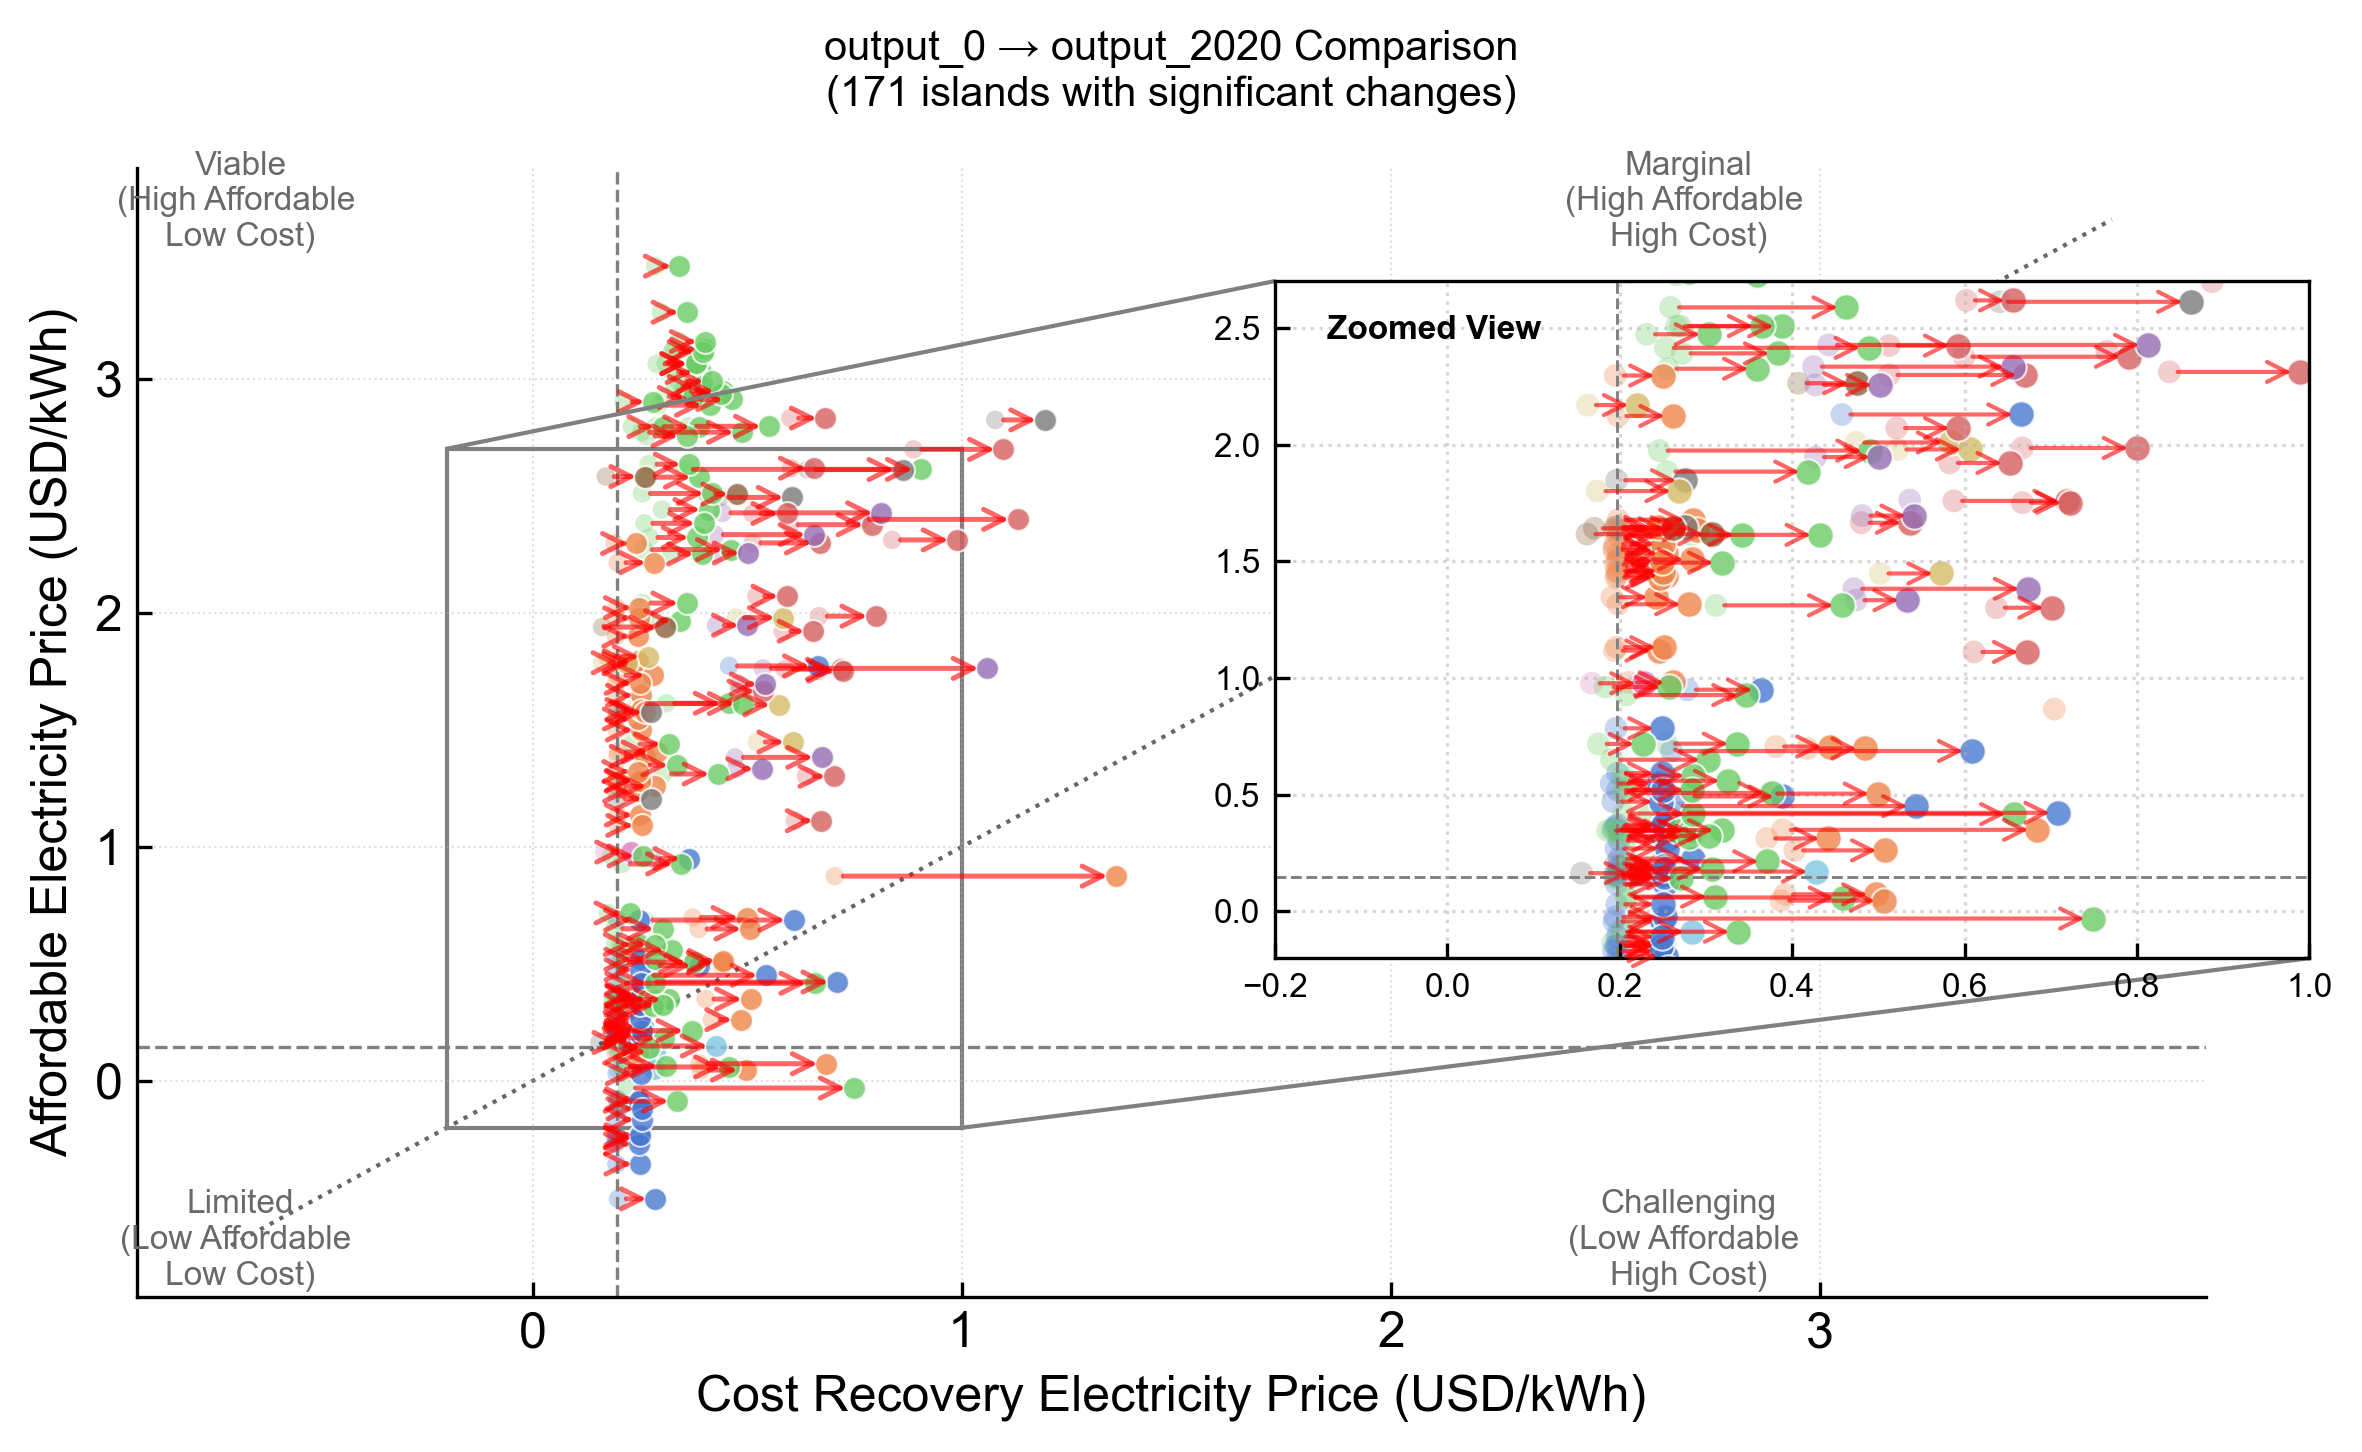


变化分析结果:
  - 总岛屿数量: 1832
  - 显著变化岛屿数量: 171 (9.3%)
  - 平均位置变化: 0.0131
  - 最大位置变化: 0.6551

--- 正在处理对比: output_0 vs output_2050 ---


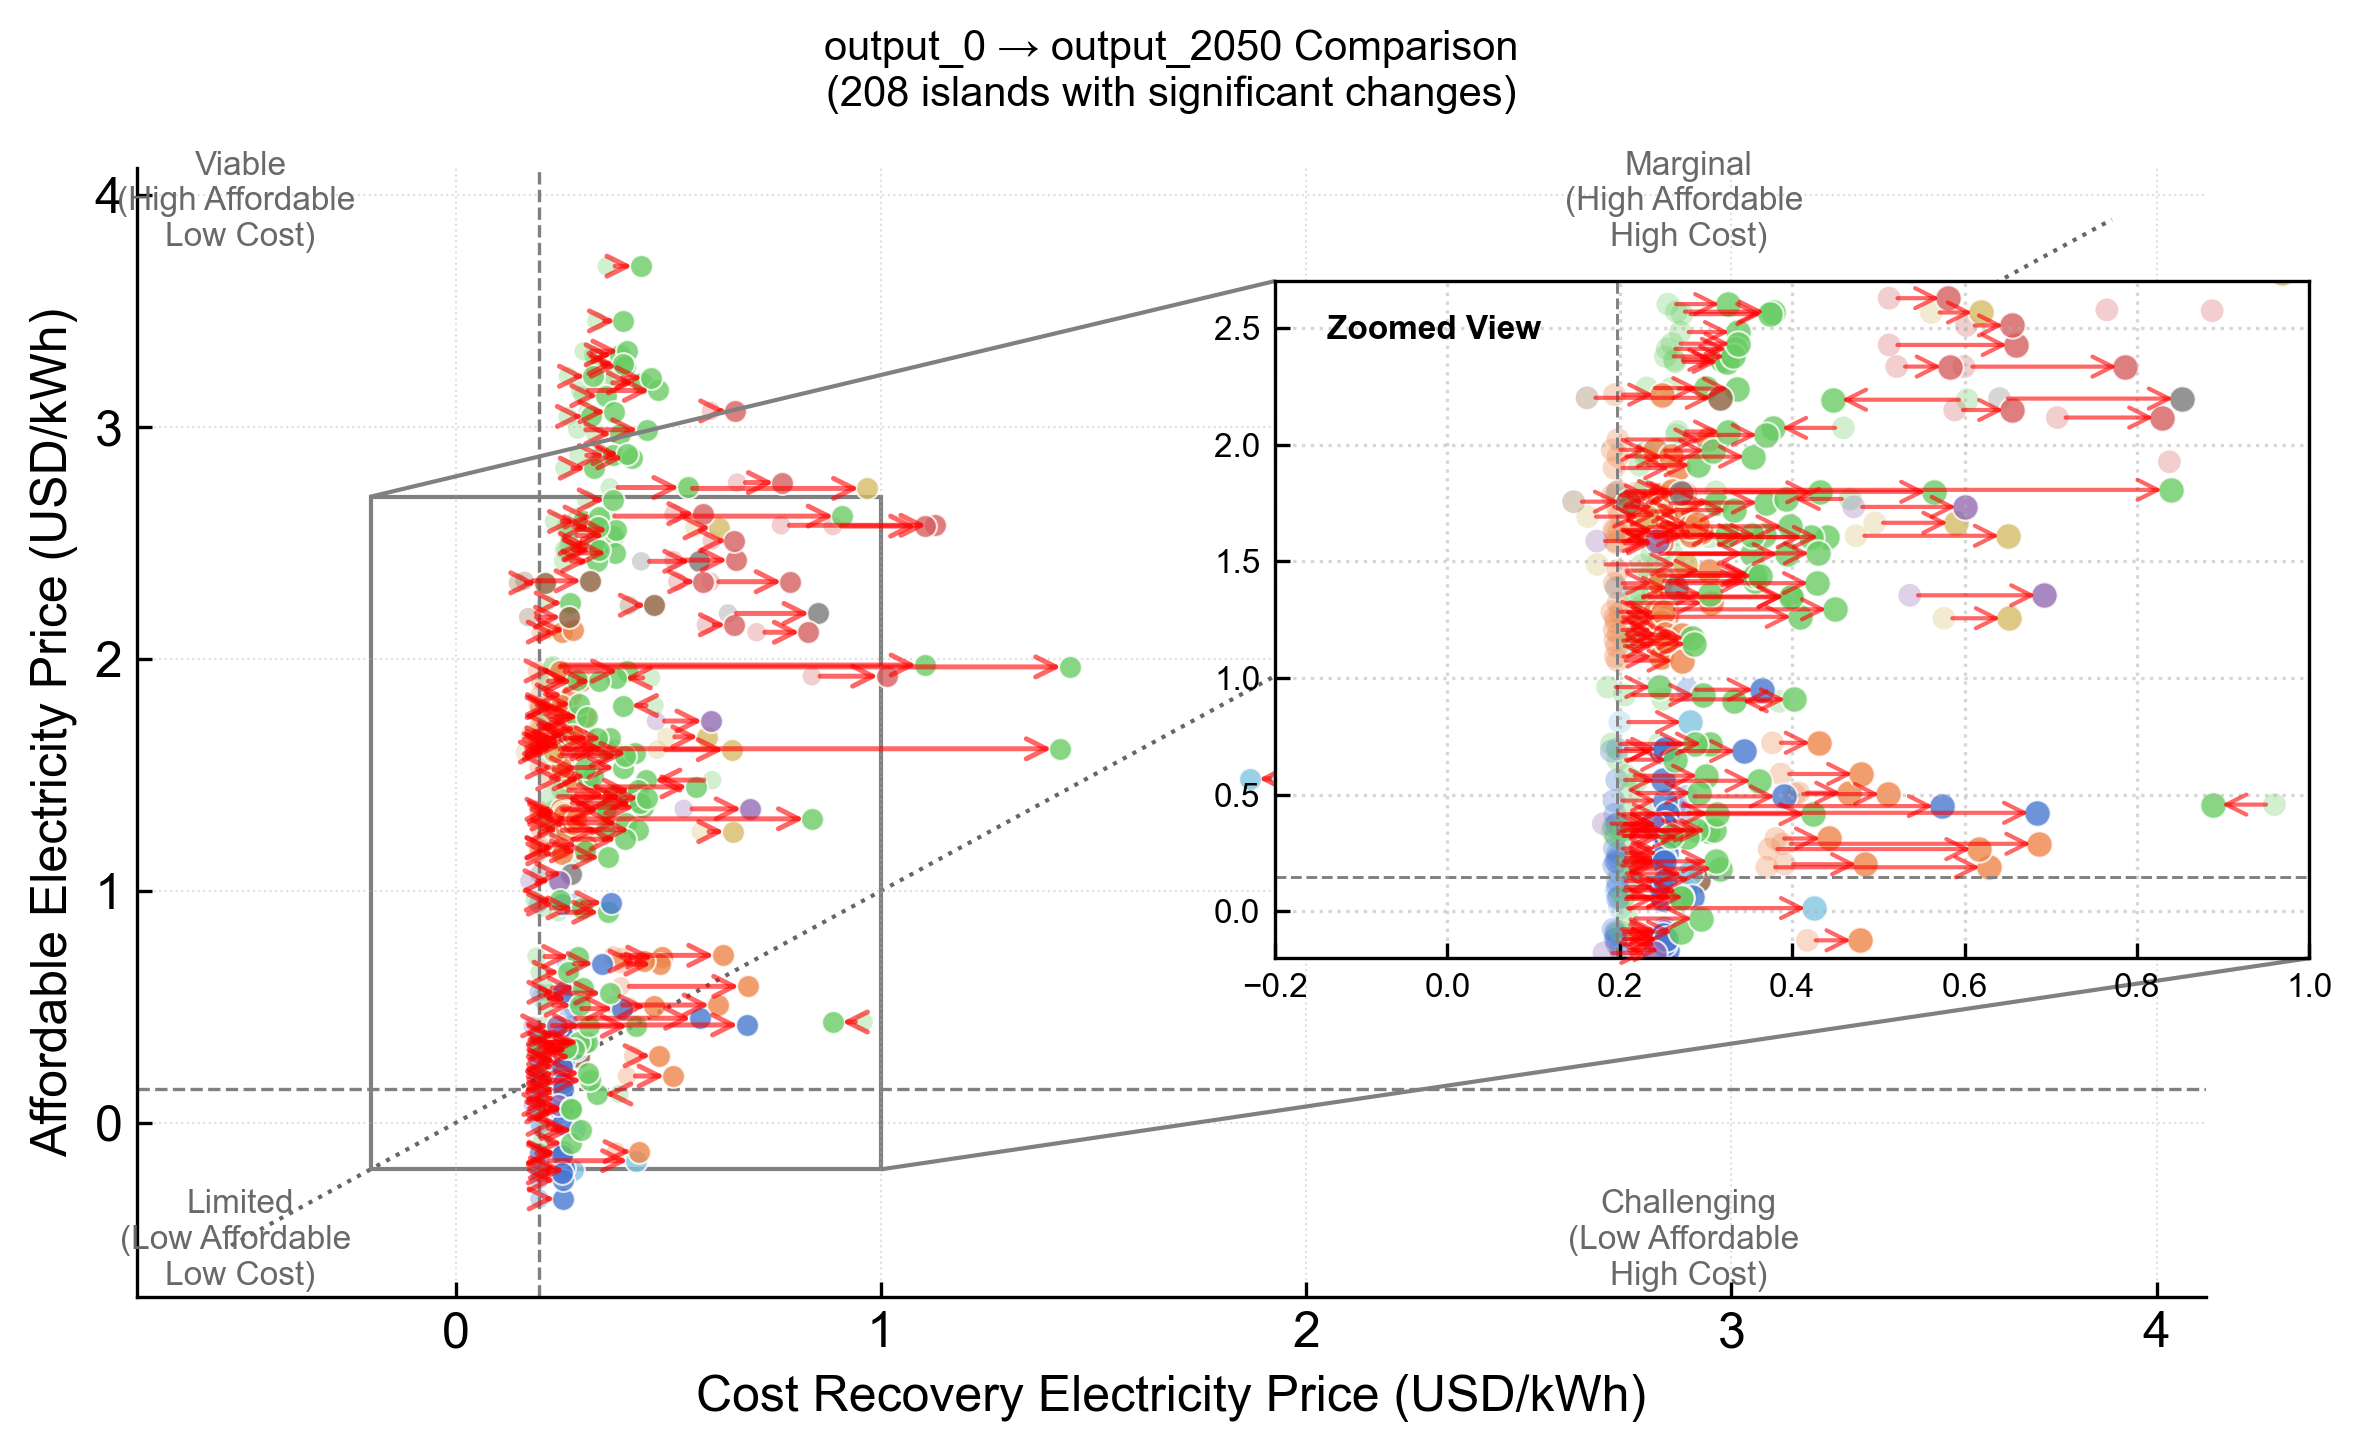


变化分析结果:
  - 总岛屿数量: 1832
  - 显著变化岛屿数量: 208 (11.4%)
  - 平均位置变化: 0.0172
  - 最大位置变化: 1.2177

--- 生成单独的图例（包含实际出现的13个区域）---


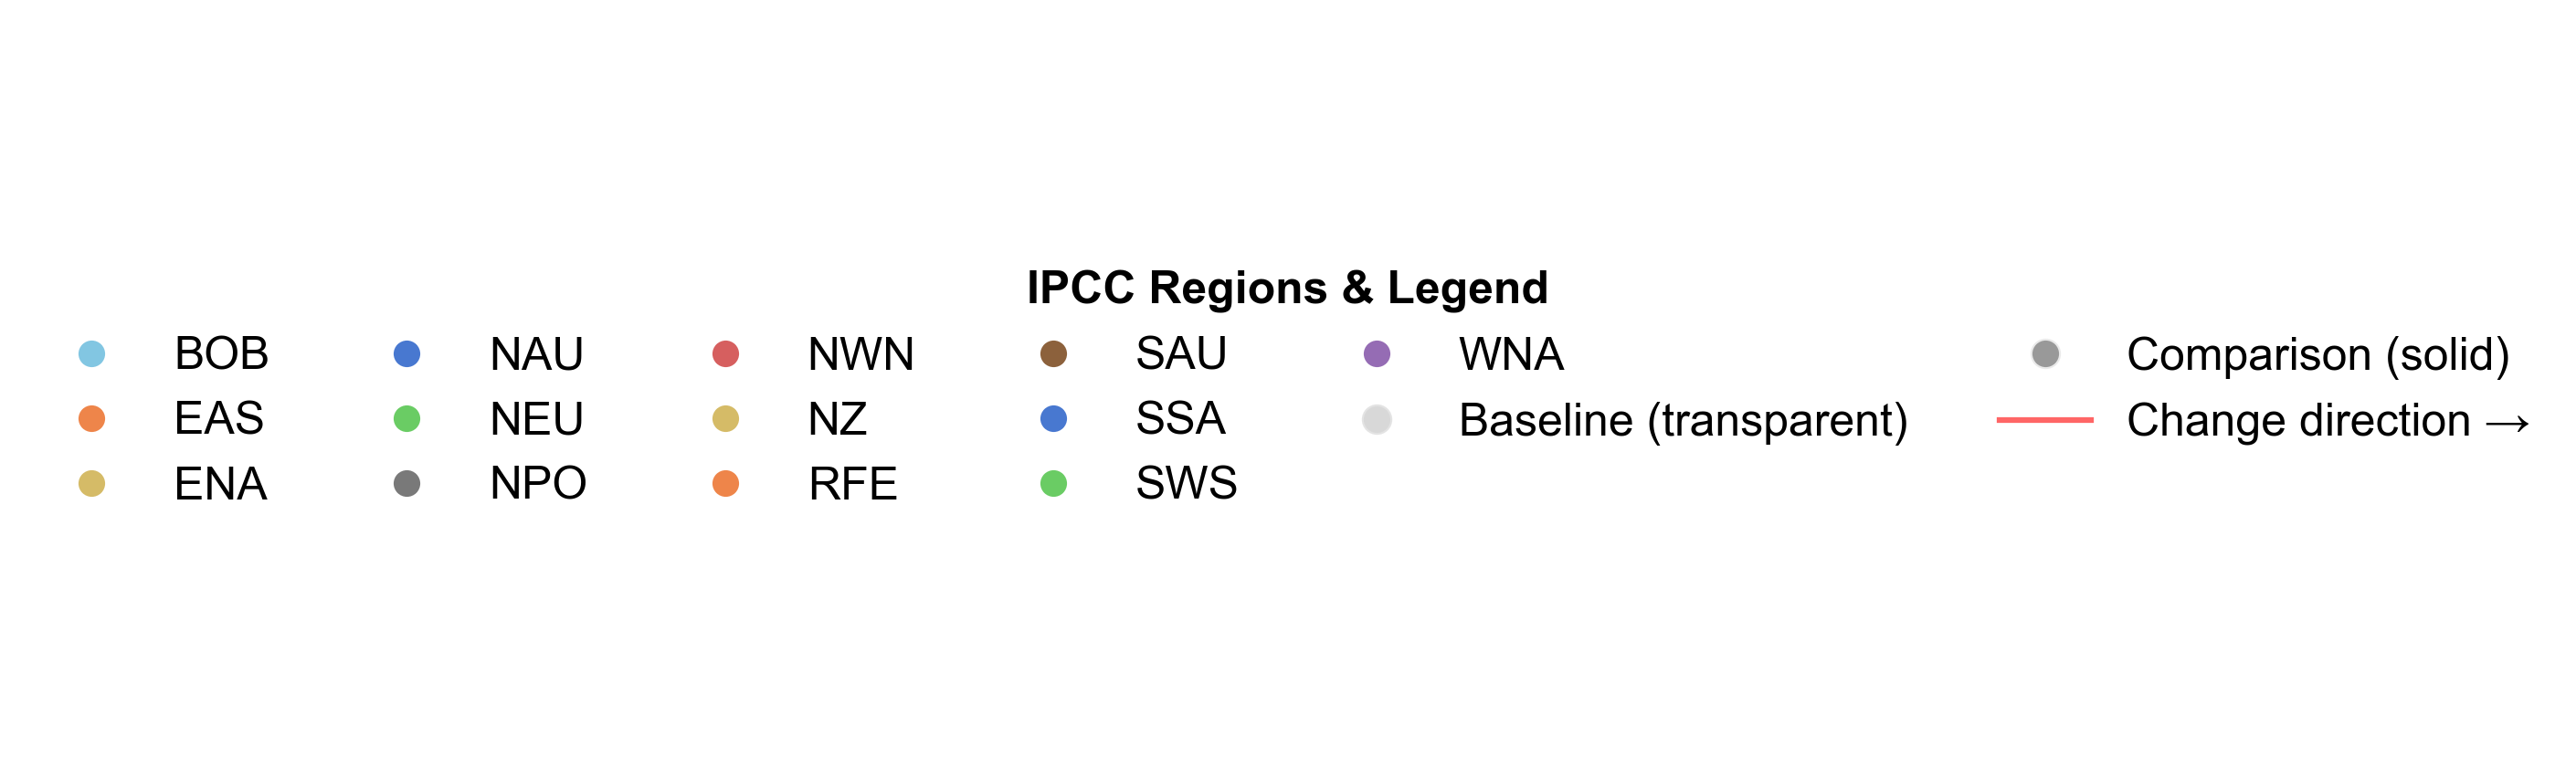

In [23]:
# 导入必要的库
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import numpy as np
import seaborn as sns # 引入 seaborn 来使用更专业的调色板
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# --- Nature 风格图表设置 ---
# 在绘图前全局设置字体、字号等参数
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 12,  # 基础字号可以稍小，具体元素再调整
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.direction': 'in', # 刻度线朝内
    'ytick.direction': 'in', # 刻度线朝内
})

# --- 数据处理函数 ---
def assign_ipcc_region(lat, lon, ipcc_regions_gdf):
    """将岛屿坐标分配到IPCC区域"""
    point = Point(lon, lat)
    # 使用 GeoDataFrame 的空间索引进行更高效的查询
    possible_matches_index = list(ipcc_regions_gdf.sindex.intersection(point.bounds))
    possible_matches = ipcc_regions_gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.contains(point)]
    if not precise_matches.empty:
        return precise_matches.iloc[0]['Acronym']
    return 'Unknown'

def calculate_position_change(df_base, df_compare):
    """计算两个情景之间的位置变化"""
    # 合并数据，基于岛屿ID
    merged = pd.merge(df_base[['island_id', 'tariff_breakeven', 'tariff_affordable', 'ipcc_region']],
                    df_compare[['island_id', 'tariff_breakeven', 'tariff_affordable', 'ipcc_region']],
                    on='island_id', suffixes=('_base', '_compare'))

    # 只有成本回收电价会变，因此变化的距离只需要相减
    merged['position_change'] = abs(merged['tariff_breakeven_compare'] - merged['tariff_breakeven_base'])

    return merged

# --- 核心绘图函数（修改版本）---
def plot_scenario_comparison(df_base, df_compare, color_map, zoom_config,
                            base_scenario, compare_scenario, change_threshold=0.05):
    """
    绘制两个情景间的位置变化对比图

    Args:
        df_base (pd.DataFrame): 基准情景数据
        df_compare (pd.DataFrame): 对比情景数据
        color_map (dict): IPCC区域到颜色的映射字典
        zoom_config (dict): 放大视图的配置字典
        base_scenario (str): 基准情景名称
        compare_scenario (str): 对比情景名称
        change_threshold (float): 位置变化阈值，超过此值的点会被突出显示
    """
    if df_base.empty or df_compare.empty:
        print(f"情景数据为空，跳过绘图。")
        return

    # 计算位置变化
    change_data = calculate_position_change(df_base, df_compare)

    # 识别有显著变化的岛屿
    significant_changes = change_data[change_data['position_change'] > change_threshold]

    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

    unique_regions = sorted(df_base['ipcc_region'].unique())

    # 只绘制有显著变化的点，每对点使用相同的y轴偏移保持平行
    if not significant_changes.empty:
        # 设置随机种子确保结果可重复
        np.random.seed(42)
        
        # 为每个岛屿生成一个固定的y轴偏移，保证一对点平行
        significant_changes_copy = significant_changes.copy()
        significant_changes_copy['y_jitter'] = np.random.normal(0, 0.3, len(significant_changes_copy))
        
        # 绘制基准情景中有显著变化的点（透明点）
        for region in unique_regions:
            # 筛选该区域中有显著变化的岛屿
            region_changes = significant_changes_copy[significant_changes_copy['ipcc_region_base'] == region]
            if not region_changes.empty:
                ax.scatter(region_changes['tariff_breakeven_base'], 
                          region_changes['tariff_affordable_base'] + region_changes['y_jitter'],
                          color=color_map[region], alpha=0.3, s=20,
                          edgecolors='none', zorder=1, label=f'{region} ({base_scenario})')

        # 绘制对比情景中有显著变化的点（实点）
        for region in unique_regions:
            region_changes = significant_changes_copy[significant_changes_copy['ipcc_region_base'] == region]
            if not region_changes.empty:
                ax.scatter(region_changes['tariff_breakeven_compare'], 
                          region_changes['tariff_affordable_compare'] + region_changes['y_jitter'],
                          color=color_map[region], alpha=0.8, s=30,
                          edgecolors='white', linewidth=0.5, zorder=3)

        # 绘制箭头显示变化方向，使用偏移后的坐标
        for _, row in significant_changes_copy.iterrows():
            x1, y1 = row['tariff_breakeven_base'], row['tariff_affordable_base'] + row['y_jitter']
            x2, y2 = row['tariff_breakeven_compare'], row['tariff_affordable_compare'] + row['y_jitter']
            
            # 使用annotate绘制箭头
            ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                       arrowprops=dict(arrowstyle='->', color='red', alpha=0.6, lw=1.2),
                       zorder=4)

    # --- 设置坐标轴和标题 ---
    ax.set_xlabel('Cost Recovery Electricity Price (USD/kWh)')
    ax.set_ylabel('Affordable Electricity Price (USD/kWh)')
    ax.set_title(f'{base_scenario} → {compare_scenario} Comparison\n'
                f'({len(significant_changes)} islands with significant changes)',
                fontsize=10, pad=15)

    # --- "Despine" - 移除顶部和右侧轴线 ---
    ax.spines[['right', 'top']].set_visible(False)

    # --- 添加辅助线（使用基准情景的中位数）---
    median_breakeven = df_base['tariff_breakeven'].median()
    median_affordable = df_base['tariff_affordable'].median()
    ax.axvline(x=median_breakeven, color='grey', linestyle='--', linewidth=0.8, zorder=2)
    ax.axhline(y=median_affordable, color='grey', linestyle='--', linewidth=0.8, zorder=2)

    # 45度线
    lim_min = min(ax.get_xlim()[0], ax.get_ylim()[0])
    lim_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([lim_min, lim_max], [lim_min, lim_max], color='black', linestyle=':',
            alpha=0.6, linewidth=1, zorder=1)
    ax.grid(True, linestyle=':', alpha=0.4, linewidth=0.5, zorder=0)

    # --- 添加象限注释 ---
    quadrant_text_props = dict(ha='center', va='center', fontsize=8, color='dimgray')
    ax.text(0.05, 0.97, 'Viable\n(High Affordable \nLow Cost)', transform=ax.transAxes, **quadrant_text_props)
    ax.text(0.75, 0.97, 'Marginal\n(High Affordable \nHigh Cost)', transform=ax.transAxes, **quadrant_text_props)
    ax.text(0.05, 0.05, 'Limited\n(Low Affordable \nLow Cost)', transform=ax.transAxes, **quadrant_text_props)
    ax.text(0.75, 0.05, 'Challenging\n(Low Affordable \nHigh Cost)', transform=ax.transAxes, **quadrant_text_props)

    # --- 创建放大视图 ---
    # 筛选放大区域内有显著变化的点
    zoom_significant_changes = significant_changes_copy[
        (significant_changes_copy['tariff_breakeven_base'].between(zoom_config['x_min'], zoom_config['x_max']) |
         significant_changes_copy['tariff_breakeven_compare'].between(zoom_config['x_min'], zoom_config['x_max'])) &
        (significant_changes_copy['tariff_affordable_base'].between(zoom_config['y_min'], zoom_config['y_max']) |
         significant_changes_copy['tariff_affordable_compare'].between(zoom_config['y_min'], zoom_config['y_max']))
    ]

    if not zoom_significant_changes.empty:
        inset_ax = ax.inset_axes([0.55, 0.3, 0.5, 0.6])
        
        # 设置随机种子确保结果可重复
        np.random.seed(42)
        
        # 为放大视图中的点生成新的y偏移（较小的偏移量）
        zoom_significant_changes_copy = zoom_significant_changes.copy()
        zoom_significant_changes_copy['y_jitter_zoom'] = np.random.normal(0, 0.3, len(zoom_significant_changes_copy))

        # 放大视图中的基准情景（透明）
        for region in unique_regions:
            region_changes = zoom_significant_changes_copy[zoom_significant_changes_copy['ipcc_region_base'] == region]
            if len(region_changes) > 0:
                inset_ax.scatter(region_changes['tariff_breakeven_base'], 
                               region_changes['tariff_affordable_base'] + region_changes['y_jitter_zoom'],
                               color=color_map[region], alpha=0.3, s=30,
                               edgecolors='none')

        # 放大视图中的对比情景（实点）
        for region in unique_regions:
            region_changes = zoom_significant_changes_copy[zoom_significant_changes_copy['ipcc_region_base'] == region]
            if len(region_changes) > 0:
                inset_ax.scatter(region_changes['tariff_breakeven_compare'], 
                               region_changes['tariff_affordable_compare'] + region_changes['y_jitter_zoom'],
                               color=color_map[region], alpha=0.8, s=40,
                               edgecolors='white', linewidth=0.5)

        # 绘制放大视图中的箭头，使用偏移后的坐标
        for _, row in zoom_significant_changes_copy.iterrows():
            x1, y1 = row['tariff_breakeven_base'], row['tariff_affordable_base'] + row['y_jitter_zoom']
            x2, y2 = row['tariff_breakeven_compare'], row['tariff_affordable_compare'] + row['y_jitter_zoom']
            
            # 使用annotate绘制箭头（在放大视图中稍微小一些）
            inset_ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                           arrowprops=dict(arrowstyle='->', color='red', alpha=0.6, lw=1.0))

        # 中位线
        inset_ax.axvline(x=median_breakeven, color='grey', linestyle='--', linewidth=0.7, zorder=1)
        inset_ax.axhline(y=median_affordable, color='grey', linestyle='--', linewidth=0.7, zorder=1)

        # 设置放大视图范围和样式
        inset_ax.set_xlim(zoom_config['x_min'], zoom_config['x_max'])
        inset_ax.set_ylim(zoom_config['y_min'], zoom_config['y_max'])
        inset_ax.tick_params(labelsize=8)
        inset_ax.grid(True, linestyle=':', alpha=0.5)
        inset_ax.text(0.05, 0.95, 'Zoomed View', transform=inset_ax.transAxes,
                    ha='left', va='top', fontsize=8, weight='bold')

        # 添加连接线
        mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5")

    # --- 调整并保存/显示 ---
    fig.tight_layout()
    plt.show()

    # --- 打印统计信息 ---
    print(f"\n变化分析结果:")
    print(f"  - 总岛屿数量: {len(change_data)}")
    print(f"  - 显著变化岛屿数量: {len(significant_changes)} ({len(significant_changes)/len(change_data)*100:.1f}%)")       
    print(f"  - 平均位置变化: {change_data['position_change'].mean():.4f}")
    print(f"  - 最大位置变化: {change_data['position_change'].max():.4f}")

# --- 单独生成图例的函数（修改版本，只显示实际使用的区域）---
def create_legend_only(color_map, actual_regions):
    """创建单独的图例图，只显示实际出现的区域"""
    fig_legend = plt.figure(figsize=(6, 3), dpi=300)

    # 创建图例项，只包括实际出现的区域
    legend_elements = []
    for region in sorted(actual_regions):
        if region in color_map:
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                            markerfacecolor=color_map[region], markersize=8,
                                            label=region))

    # 添加说明性图例项
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                    markerfacecolor='gray', alpha=0.3, markersize=8,
                                    label='Baseline (transparent)'))
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                    markerfacecolor='gray', alpha=0.8, markersize=8,
                                    label='Comparison (solid)'))
    # 更新箭头图例
    from matplotlib.patches import FancyArrowPatch
    arrow_patch = FancyArrowPatch((0, 0), (1, 0), 
                                arrowstyle='->', 
                                color='red', alpha=0.6,
                                mutation_scale=15)
    legend_elements.append(plt.Line2D([0], [0], color='red', alpha=0.6,
                                    label='Change direction →'))

    # 根据实际区域数量调整ncol
    ncol = min(len(actual_regions) + 3, 6)  # 最多6列

    # 创建图例
    legend = fig_legend.legend(handles=legend_elements, loc='center', frameon=False,
                            title='IPCC Regions & Legend', title_fontproperties={'weight':'bold'}, ncol=ncol)

    # 移除坐标轴
    fig_legend.gca().set_axis_off()

    plt.tight_layout()
    plt.show()

# ===== 主程序 =====
if __name__ == '__main__':

    # --- 1. 数据加载和预处理 ---
    try:
        ipcc_regions = gpd.read_file("IPCC-WGI-reference-regions-v4.geojson")
        ipcc_regions.sindex
    except Exception as e:
        print(f"无法加载 geojson 文件: {e}. 将无法分配IPCC区域。")
        ipcc_regions = gpd.GeoDataFrame({'Acronym': [], 'geometry': []})
        df['ipcc_region'] = 'Unknown'

    if not ipcc_regions.empty:
        print("正在为岛屿分配IPCC区域...")
        df['ipcc_region'] = df.apply(
            lambda row: assign_ipcc_region(row['lat'], row['lon'], ipcc_regions), axis=1
        )

    # --- 2. 绘图配置 ---
    MIN_ISLANDS_PER_REGION = 5
    ZOOM_BOX = {
        'x_min': -0.2, 'x_max': 1.0,
        'y_min': -0.2, 'y_max': 2.7
    }

    # 筛选出所有情景中都出现且岛屿数量>5的区域，以保证颜色一致性
    region_counts = df['ipcc_region'].value_counts()
    valid_regions = region_counts[region_counts > MIN_ISLANDS_PER_REGION].index.tolist()

    # 使用Seaborn创建一个更专业的调色板
    colors = sns.color_palette('muted', n_colors=len(valid_regions))
    region_color_map = {region: colors[i] for i, region in enumerate(valid_regions)}

    # --- 3. 定义对比情景对 ---
    comparison_pairs = [
        ('output_0', 'output_2020'),
        ('output_0', 'output_2050')
    ]

    print(f"将进行以下情景对比: {comparison_pairs}")
    
    # 记录实际出现在图中的区域
    actual_regions_in_plots = set()

    for base_scenario, compare_scenario in comparison_pairs:
        print(f"\n--- 正在处理对比: {base_scenario} vs {compare_scenario} ---")

        # 筛选数据
        df_base = df[(df['scenario'] == base_scenario) & (df['ipcc_region'].isin(valid_regions))].copy()
        df_compare = df[(df['scenario'] == compare_scenario) & (df['ipcc_region'].isin(valid_regions))].copy()

        if not df_base.empty and not df_compare.empty:
            # 计算位置变化来确定实际出现的区域
            change_data = calculate_position_change(df_base, df_compare)
            significant_changes = change_data[change_data['position_change'] > 0.1]
            
            # 添加实际出现的区域到集合中
            if not significant_changes.empty:
                actual_regions_in_plots.update(significant_changes['ipcc_region_base'].unique())
            
            plot_scenario_comparison(
                df_base=df_base,
                df_compare=df_compare,
                color_map=region_color_map,
                zoom_config=ZOOM_BOX,
                base_scenario=base_scenario,
                compare_scenario=compare_scenario,
                change_threshold=0.05  # 可以调整这个阈值来控制哪些变化被认为是"显著"的
            )
        else:
            print(f"数据不足，跳过 {base_scenario} vs {compare_scenario} 的对比")

    # --- 4. 最后单独生成一次图例，只显示实际出现的区域 ---
    if actual_regions_in_plots:
        print(f"\n--- 生成单独的图例（包含实际出现的{len(actual_regions_in_plots)}个区域）---")
        create_legend_only(region_color_map, actual_regions_in_plots)
    else:
        print("\n--- 没有发现显著变化的区域，跳过图例生成 ---")

发现在至少一个scenario中有显著变化的区域: 20 个
区域列表: ['GIC', 'NWN', 'ENA', 'SEA', 'SAU', 'SIO', 'SWS', 'NEN', 'SPO', 'SSA', 'RFE', 'ARP', 'MDG', 'NPO', 'NEU', 'BOB', 'NAU', 'WNA', 'NZ', 'EAS']


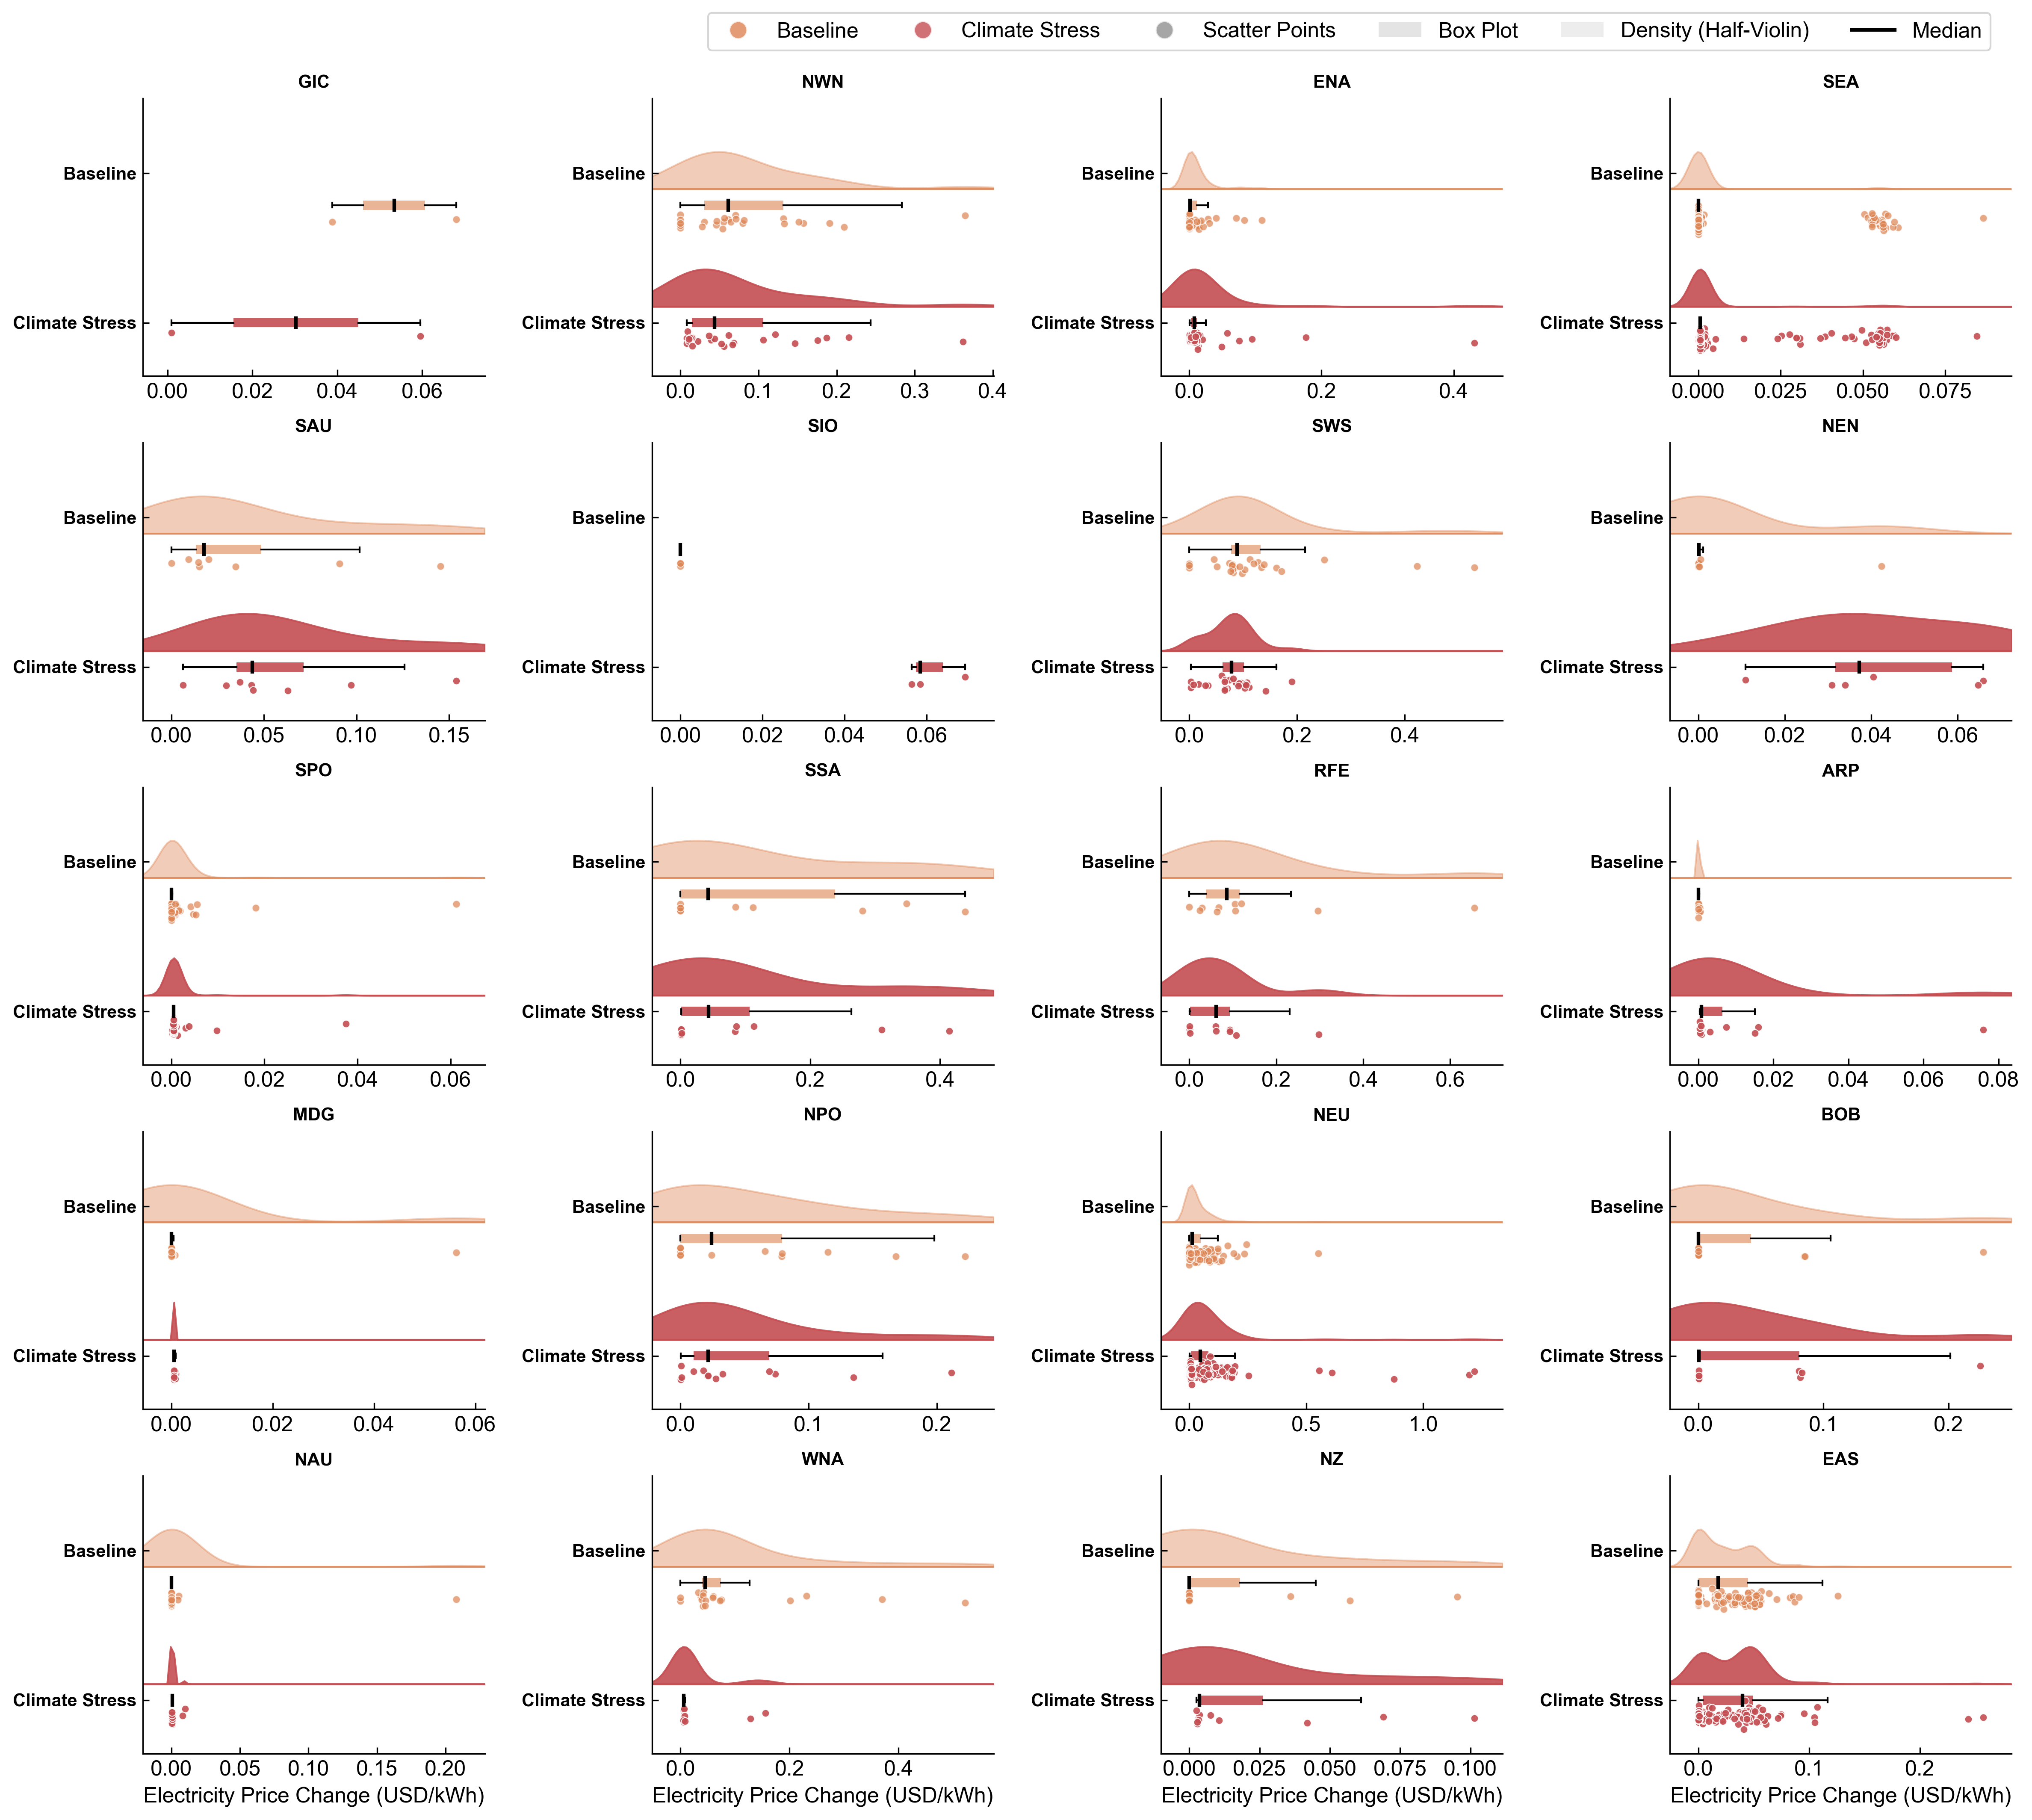


=== 区域变化统计 ===

GIC:
  2020: 2 islands, median = 0.053, max = 0.068
  2050: 2 islands, median = 0.030, max = 0.060

NWN:
  2020: 25 islands, median = 0.061, max = 0.365
  2050: 25 islands, median = 0.044, max = 0.362

ENA:
  2020: 45 islands, median = 0.001, max = 0.110
  2050: 45 islands, median = 0.007, max = 0.431

SEA:
  2020: 698 islands, median = 0.000, max = 0.087
  2050: 698 islands, median = 0.001, max = 0.085

SAU:
  2020: 8 islands, median = 0.018, max = 0.145
  2050: 8 islands, median = 0.044, max = 0.154

SIO:
  2020: 3 islands, median = 0.000, max = 0.000
  2050: 3 islands, median = 0.058, max = 0.069

SWS:
  2020: 26 islands, median = 0.089, max = 0.529
  2050: 26 islands, median = 0.078, max = 0.190

NEN:
  2020: 6 islands, median = 0.000, max = 0.042
  2050: 6 islands, median = 0.037, max = 0.066

SPO:
  2020: 84 islands, median = 0.000, max = 0.061
  2050: 84 islands, median = 0.001, max = 0.037

SSA:
  2020: 10 islands, median = 0.043, max = 0.439
  2050: 10 islands

In [24]:
from scipy import stats

def create_raincloud_plot(data_2020, data_2050, ax, region_name, color_2020, color_2050):
    """
    创建改进的云雨图：每个scenario占据上下两个区域，每个区域内从下到上是点-箱线图-半小提琴图
    
    Args:
        data_2020: 2020情景的变化值数据
        data_2050: 2050情景的变化值数据
        ax: matplotlib轴对象
        region_name: IPCC区域名称
        color_2020, color_2050: 两个情景的颜色
    """
    # 计算数据范围
    all_data = np.concatenate([data_2020, data_2050])
    if len(all_data) == 0:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{region_name}', fontsize=10, pad=10, fontweight='bold')
        return
        
    x_min, x_max = all_data.min(), all_data.max()
    x_range = x_max - x_min if x_max != x_min else 1
    x_padding = x_range * 0.1
    
    # 设置y轴位置（分为上下两个区域，层级更紧密）
    # 2020 scenario（上半部分：0.52-1.0）
    y_2020_points = 0.56    # 2020散点
    y_2020_box = 0.62       # 2020箱线图
    y_2020_violin = 0.68    # 2020小提琴图基准线
    
    # 2050 scenario（下半部分：0.0-0.48）
    y_2050_points = 0.12    # 2050散点
    y_2050_box = 0.18       # 2050箱线图
    y_2050_violin = 0.24    # 2050小提琴图基准线
    
    np.random.seed(42)  # 确保结果可重现
    
    # === 2020 Scenario（上半部分）===
    if len(data_2020) > 0:
        # 1. 散点图（最下层）
        y_jitter_2020 = np.random.normal(y_2020_points, 0.015, len(data_2020))
        ax.scatter(data_2020, y_jitter_2020, alpha=0.7, s=18, 
                  color=color_2020, edgecolors='white', linewidth=0.5, zorder=3)
        
        # 2. 箱线图（中间层）
        q25, q50, q75 = np.percentile(data_2020, [25, 50, 75])
        iqr = q75 - q25
        whisker_low = max(data_2020.min(), q25 - 1.5 * iqr)
        whisker_high = min(data_2020.max(), q75 + 1.5 * iqr)
        
        # 箱体（稍微小一些）
        box_height = 0.035
        ax.add_patch(plt.Rectangle((q25, y_2020_box - box_height/2), q75 - q25, box_height,
                                  facecolor=color_2020, alpha=0.6, zorder=2))
        # 中位数线
        ax.plot([q50, q50], [y_2020_box - box_height/2, y_2020_box + box_height/2], 
               color='black', linewidth=2, zorder=4)
        # 须线
        ax.plot([whisker_low, q25], [y_2020_box, y_2020_box], color='black', linewidth=1, zorder=2)
        ax.plot([q75, whisker_high], [y_2020_box, y_2020_box], color='black', linewidth=1, zorder=2)
        ax.plot([whisker_low, whisker_low], [y_2020_box - box_height/4, y_2020_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        ax.plot([whisker_high, whisker_high], [y_2020_box - box_height/4, y_2020_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        
        # 3. 半小提琴图（上层，只显示向上的部分）
        if len(data_2020) > 3:
            try:
                kde_2020 = stats.gaussian_kde(data_2020)
                x_kde = np.linspace(x_min - x_padding, x_max + x_padding, 100)
                density_2020 = kde_2020(x_kde)
                # 归一化密度并缩放（稍微小一些）
                density_2020_scaled = density_2020 / density_2020.max() * 0.14
                
                # 只向上填充（半小提琴）
                ax.fill_between(x_kde, y_2020_violin, y_2020_violin + density_2020_scaled, 
                              alpha=0.4, color=color_2020, zorder=1)
                # 底边线
                ax.plot(x_kde, [y_2020_violin] * len(x_kde), color=color_2020, linewidth=1, alpha=0.8, zorder=1)
            except:
                pass
    
    # === 2050 Scenario（下半部分）===
    if len(data_2050) > 0:
        # 1. 散点图（最下层）
        y_jitter_2050 = np.random.normal(y_2050_points, 0.015, len(data_2050))
        ax.scatter(data_2050, y_jitter_2050, alpha=0.9, s=18, 
                  color=color_2050, edgecolors='white', linewidth=0.5, zorder=3)
        
        # 2. 箱线图（中间层）
        q25, q50, q75 = np.percentile(data_2050, [25, 50, 75])
        iqr = q75 - q25
        whisker_low = max(data_2050.min(), q25 - 1.5 * iqr)
        whisker_high = min(data_2050.max(), q75 + 1.5 * iqr)
        
        # 箱体（稍微小一些）
        box_height = 0.035
        ax.add_patch(plt.Rectangle((q25, y_2050_box - box_height/2), q75 - q25, box_height,
                                  facecolor=color_2050, alpha=0.9, zorder=2))
        # 中位数线
        ax.plot([q50, q50], [y_2050_box - box_height/2, y_2050_box + box_height/2], 
               color='black', linewidth=2, zorder=4)
        # 须线
        ax.plot([whisker_low, q25], [y_2050_box, y_2050_box], color='black', linewidth=1, zorder=2)
        ax.plot([q75, whisker_high], [y_2050_box, y_2050_box], color='black', linewidth=1, zorder=2)
        ax.plot([whisker_low, whisker_low], [y_2050_box - box_height/4, y_2050_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        ax.plot([whisker_high, whisker_high], [y_2050_box - box_height/4, y_2050_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        
        # 3. 半小提琴图（上层，只显示向上的部分）
        if len(data_2050) > 3:
            try:
                kde_2050 = stats.gaussian_kde(data_2050)
                x_kde = np.linspace(x_min - x_padding, x_max + x_padding, 100)
                density_2050 = kde_2050(x_kde)
                # 归一化密度并缩放（稍微小一些）
                density_2050_scaled = density_2050 / density_2050.max() * 0.14
                
                # 只向上填充（半小提琴）
                ax.fill_between(x_kde, y_2050_violin, y_2050_violin + density_2050_scaled, 
                              alpha=0.9, color=color_2050, zorder=1)
                # 底边线
                ax.plot(x_kde, [y_2050_violin] * len(x_kde), color=color_2050, linewidth=1, alpha=0.8, zorder=1)
            except:
                pass
    
    # 4. 设置轴和标签
    ax.set_ylim(-0.02, 1.02)
    
    # 设置y轴标签，标识两个scenario区域
    ax.set_yticks([0.18, 0.74])  # 在每个scenario的中间位置
    ax.set_yticklabels(['Climate Stress', 'Baseline'], fontsize=10, fontweight='bold')
    
    # 添加分隔线
    # ax.axhline(y=0.5, color='black', linestyle='-', alpha=0.4, linewidth=1, zorder=0)  # 主分隔线
    
    # 删除内部参考线，让视觉更简洁
    
    ax.set_title(f'{region_name}', fontsize=10, pad=6, fontweight='bold')
    # ax.grid(True, alpha=0.3, axis='x')
    ax.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # 设置x轴范围
    ax.set_xlim(x_min - x_padding, x_max + x_padding)


# 主程序：创建多子图云雨图
if __name__ == '__main__':
    # 计算变化数据（使用之前的逻辑）
    df_base_2020 = df[(df['scenario'] == 'output_0') & (df['ipcc_region'].isin(valid_regions))].copy()
    df_compare_2020 = df[(df['scenario'] == 'output_2020') & (df['ipcc_region'].isin(valid_regions))].copy()
    df_compare_2050 = df[(df['scenario'] == 'output_2050') & (df['ipcc_region'].isin(valid_regions))].copy()

    # 计算变化
    change_2020 = calculate_position_change(df_base_2020, df_compare_2020)
    change_2050 = calculate_position_change(df_base_2020, df_compare_2050)
    
    # 筛选有显著变化的区域
    significant_2020 = change_2020[change_2020['position_change'] > 0.05]
    significant_2050 = change_2050[change_2050['position_change'] > 0.05]
    
    # 获取在两个scenario中都有显著变化的区域
    regions_2020 = set(significant_2020['ipcc_region_base'].unique())
    regions_2050 = set(significant_2050['ipcc_region_base'].unique())
    common_regions = list(regions_2020.union(regions_2050))  # 使用并集，显示所有有变化的区域
    
    print(f"发现在至少一个scenario中有显著变化的区域: {len(common_regions)} 个")
    print(f"区域列表: {common_regions}")
    
    if len(common_regions) == 0:
        print("没有发现有显著变化的区域")
    else:
        # 计算子图布局
        n_regions = len(common_regions)
        n_cols = min(4, n_regions)  # 最多4列
        n_rows = (n_regions + n_cols - 1) // n_cols  # 向上取整
        
        # 创建图形
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), dpi=300)
        if n_regions == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.flatten()
        else:
            axes = axes.flatten()
        
        # 定义颜色
        color_2020 = '#DD8452'  
        color_2050 = '#C44E52' 
        
        # 为每个区域创建子图
        for i, region in enumerate(common_regions):
            ax = axes[i]
            
            # 获取该区域在两个scenario下的变化数据
            region_data_2020 = change_2020[change_2020['ipcc_region_base'] == region]['position_change'].values
            region_data_2050 = change_2050[change_2050['ipcc_region_base'] == region]['position_change'].values
            
            # 绘制改进的云雨图
            create_raincloud_plot(region_data_2020, region_data_2050, ax, 
                                region, color_2020, color_2050)
        
        # 隐藏多余的子图
        for i in range(n_regions, len(axes)):
            axes[i].set_visible(False)
        
        # 设置总标题和轴标签
        # fig.suptitle('IPCC Regional Changes: Layered Raincloud Plot\n(Each Scenario: Points → Box → Half-Violin)', 
        #             fontsize=14, fontweight='bold', y=0.98)
        
        # 为所有子图添加统一的x轴标签
        for i in range(n_regions):
            if i >= (n_rows-1) * n_cols:  # 最后一行
                axes[i].set_xlabel('Electricity Price Change (USD/kWh)', fontsize=12)
        
        # 添加图例
        from matplotlib.lines import Line2D
        from matplotlib.patches import Patch
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color_2020, 
                  markersize=10, label='Baseline', alpha=0.8),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color_2050, 
                  markersize=10, label='Climate Stress', alpha=0.8),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
                  markersize=10, label='Scatter Points', alpha=0.7),
            Patch(facecolor='lightgray', alpha=0.6, label='Box Plot'),
            Patch(facecolor='lightgray', alpha=0.4, label='Density (Half-Violin)'),
            Line2D([0], [0], color='black', linewidth=2, label='Median')
        ]
        fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.95), ncol=6)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.90)
        plt.show()
        
        # 打印统计信息
        print(f"\n=== 区域变化统计 ===")
        for region in common_regions:
            data_2020 = change_2020[change_2020['ipcc_region_base'] == region]['position_change'].values
            data_2050 = change_2050[change_2050['ipcc_region_base'] == region]['position_change'].values
            
            print(f"\n{region}:")
            if len(data_2020) > 0:
                print(f"  2020: {len(data_2020)} islands, median = {np.median(data_2020):.3f}, max = {np.max(data_2020):.3f}")
            if len(data_2050) > 0:
                print(f"  2050: {len(data_2050)} islands, median = {np.median(data_2050):.3f}, max = {np.max(data_2050):.3f}")


--- 正在对比三个情景，但只显示在 'output_0' 和 'output_2020' 之间有显著变化的岛屿 ---
发现 54 个有显著变化的岛屿（在 output_0 和 output_2020 之间）。


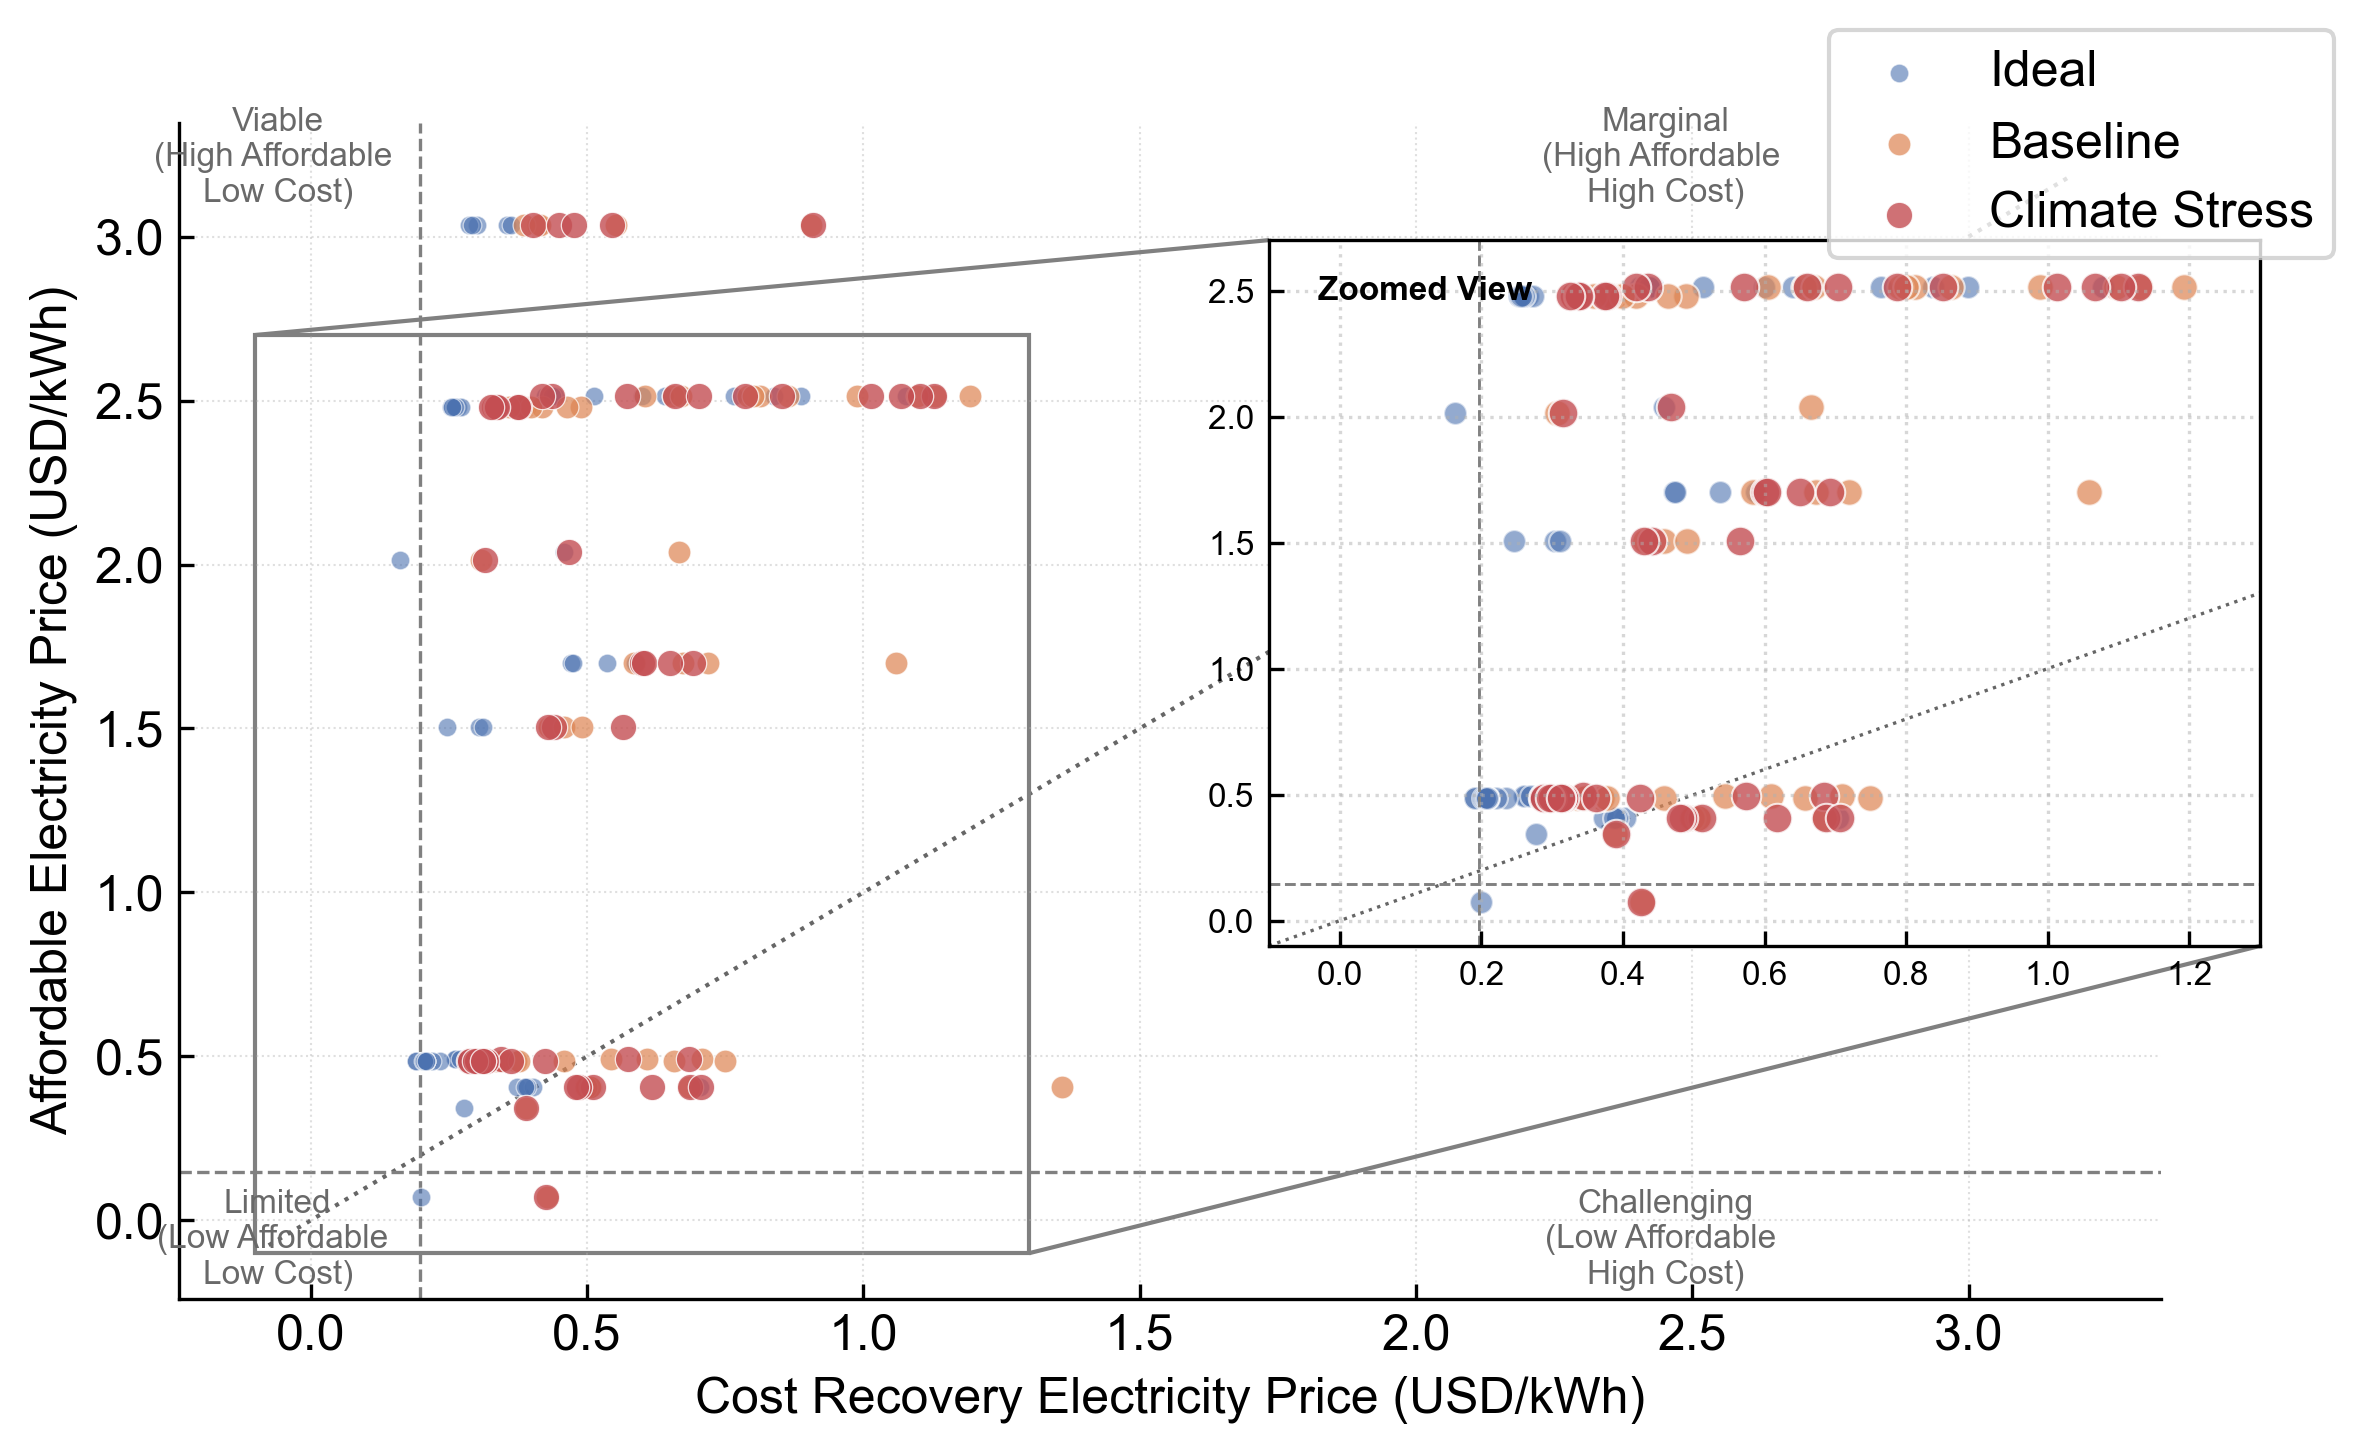


--- 统计分析结果 (仅针对显著变化的岛屿) ---
                Viable  Marginal  Limited  Challenging  \
Scenario                                                 
Ideal                3        50        0            1   
Baseline             0        53        0            1   
Climate Stress       0        53        0            1   

                Unaffordable\n(Cost > Affordable)  
Scenario                                           
Ideal                                           2  
Baseline                                       13  
Climate Stress                                 10  
--------------------------------------------------


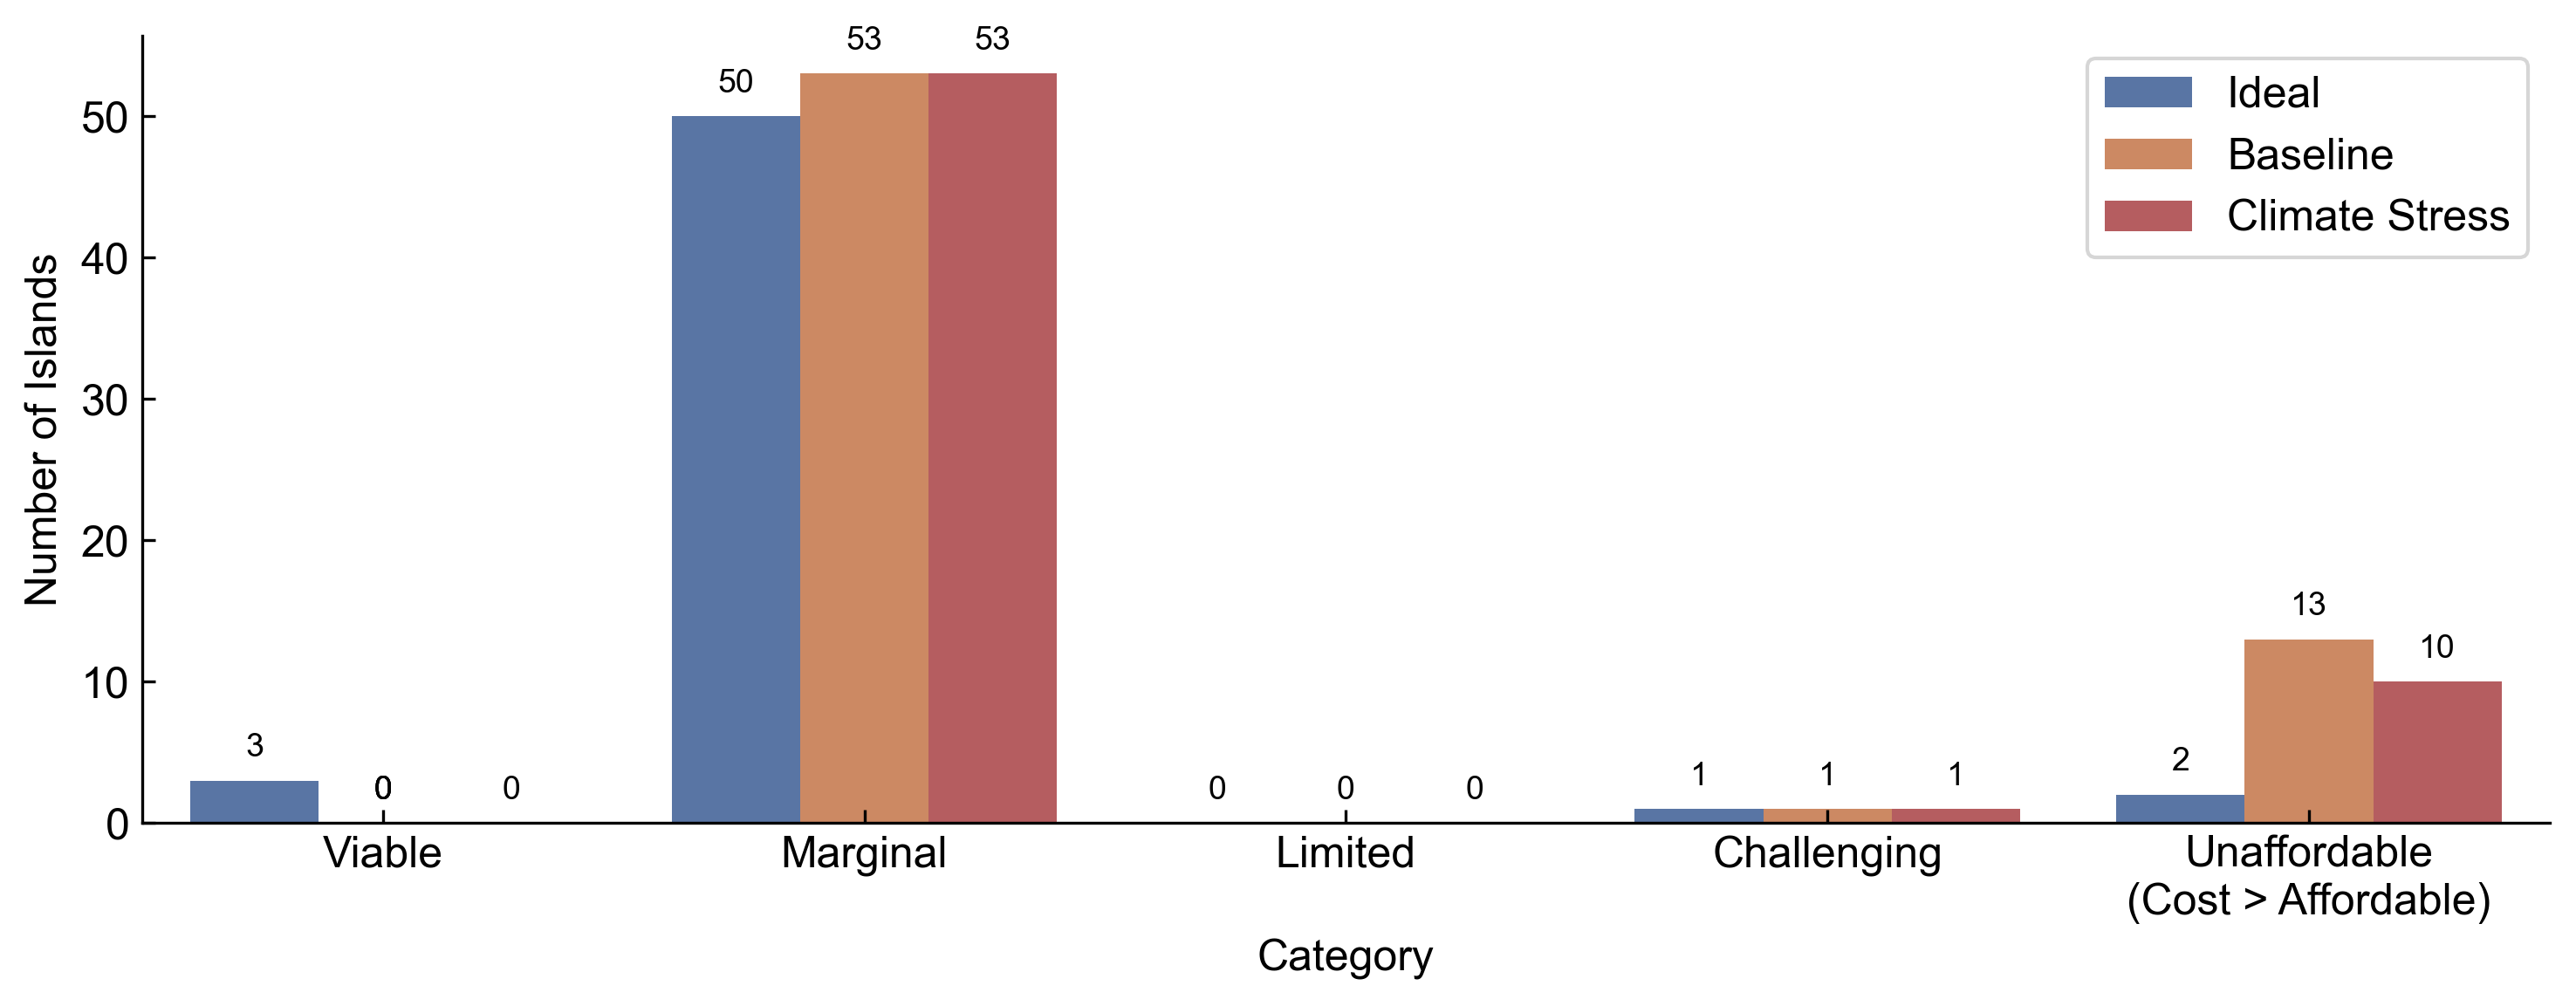

In [25]:
# 导入必要的库
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import numpy as np
import seaborn as sns # 引入 seaborn 来使用更专业的调色板
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# --- Nature 风格图表设置 ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
})

# --- 数据处理函数 ---
def assign_ipcc_region(lat, lon, ipcc_regions_gdf):
    """将岛屿坐标分配到IPCC区域"""
    point = Point(lon, lat)
    possible_matches_index = list(ipcc_regions_gdf.sindex.intersection(point.bounds))
    possible_matches = ipcc_regions_gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.contains(point)]
    if not precise_matches.empty:
        return precise_matches.iloc[0]['Acronym']
    return 'Unknown'

def calculate_position_change(df_base, df_compare):
    """计算两个情景之间的位置变化"""
    merged = pd.merge(df_base[['island_id', 'tariff_breakeven']],
                      df_compare[['island_id', 'tariff_breakeven']],
                      on='island_id', suffixes=('_base', '_compare'))
    merged['position_change'] = abs(merged['tariff_breakeven_compare'] - merged['tariff_breakeven_base'])
    return merged

# --- NEW: 新增的统计分析与绘图函数 ---
def analyze_and_plot_statistics(df_analysis, scenario_config, median_breakeven, median_affordable):
    """
    对数据进行象限和可负担性分析，并绘制条形图。
    """
    results = []
    
    # 1. 遍历每个情景进行统计
    for scenario_name, config in scenario_config.items():
        scenario_df = df_analysis[df_analysis['scenario'] == scenario_name].copy()
        if scenario_df.empty:
            continue
            
        # 定义象限条件
        is_viable = (scenario_df['tariff_breakeven'] <= median_breakeven) & (scenario_df['tariff_affordable'] >= median_affordable)
        is_marginal = (scenario_df['tariff_breakeven'] >= median_breakeven) & (scenario_df['tariff_affordable'] >= median_affordable)
        is_limited = (scenario_df['tariff_breakeven'] <= median_breakeven) & (scenario_df['tariff_affordable'] <= median_affordable)
        is_challenging = (scenario_df['tariff_breakeven'] >= median_breakeven) & (scenario_df['tariff_affordable'] <= median_affordable)
        is_unaffordable = scenario_df['tariff_breakeven'] >= scenario_df['tariff_affordable']
        
        # 统计数量
        counts = {
            'Scenario': config['label'],
            'Viable': is_viable.sum(),
            'Marginal': is_marginal.sum(),
            'Limited': is_limited.sum(),
            'Challenging': is_challenging.sum(),
            'Unaffordable\n(Cost > Affordable)': is_unaffordable.sum()
        }
        results.append(counts)
        
    if not results:
        print("没有可供分析的数据。")
        return
        
    # 2. 创建并打印统计结果的DataFrame
    stats_df = pd.DataFrame(results).set_index('Scenario')
    print("\n--- 统计分析结果 (仅针对显著变化的岛屿) ---")
    print(stats_df)
    print("-" * 50)
    
    # 3. 准备绘图数据
    stats_df_melted = stats_df.reset_index().melt(
        id_vars='Scenario',
        var_name='Category',
        value_name='Number of Islands'
    )
    
    # 提取颜色用于绘图
    palette = {config['label']: config['color'] for config in scenario_config.values()}
    
    # 4. 创建条形图
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    sns.barplot(
        data=stats_df_melted,
        x='Category',
        y='Number of Islands',
        hue='Scenario',
        palette=palette,
        ax=ax
    )
    
    # 美化图表
    # ax.set_title('Statistical Distribution of Significantly Changed Islands', fontsize=14, pad=15)
    ax.set_xlabel('Category', fontsize=12)
    ax.set_ylabel('Number of Islands', fontsize=12)
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend()  # 移除title='Scenario'
    
    # 在条形图上添加数字标签
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=9)

    fig.tight_layout()
    plt.show()

# --- 核心绘图函数（已修改，会调用新的分析函数） ---
def plot_three_scenario_changes(df, base_scenario, final_scenario, zoom_config, scenario_config, change_threshold=0.1):
    """
    筛选出在首尾情景间有显著变化的岛屿，绘制它们的位置，并进行统计分析。
    """
    if df.empty:
        print("数据为空，跳过绘图。")
        return

    # 1. 筛选出用于计算变化的起始和最终情景数据
    df_base = df[df['scenario'] == base_scenario]
    df_final = df[df['scenario'] == final_scenario]
    
    if df_base.empty or df_final.empty:
        print(f"缺少 {base_scenario} 或 {final_scenario} 的数据，无法计算变化。")
        return

    # 2. 计算并筛选出有显著变化的岛屿
    change_data = calculate_position_change(df_base, df_final)
    significant_changes = change_data[change_data['position_change'] > change_threshold]
    
    if significant_changes.empty:
        print(f"在阈值 {change_threshold} 下未发现显著变化的岛屿。")
        return
        
    significant_island_ids = significant_changes['island_id'].unique()
    print(f"发现 {len(significant_island_ids)} 个有显著变化的岛屿（在 {base_scenario} 和 {final_scenario} 之间）。")

    # 3. 从原始数据中筛选出这些岛屿在 *所有情景* 中的数据
    df_plot = df[df['island_id'].isin(significant_island_ids)].copy()

    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

    # 4. 为每个岛屿生成固定的y轴偏移
    np.random.seed(42)
    jitter_values = np.random.normal(0, 0.3, len(significant_island_ids))
    island_jitter_map = dict(zip(significant_island_ids, jitter_values))
    df_plot['y_jitter'] = df_plot['island_id'].map(island_jitter_map)

    # 5. 循环绘制所有情景
    for scenario_name, config in scenario_config.items():
        scenario_df = df_plot[df_plot['scenario'] == scenario_name]
        if not scenario_df.empty:
            ax.scatter(
                scenario_df['tariff_breakeven'],
                scenario_df['tariff_affordable'], 
                # + scenario_df['y_jitter'],
                color=config['color'],
                alpha=config['alpha'],
                s=config['size'],
                edgecolors='white',
                linewidth=0.3,
                label=config['label'],
                zorder=config['zorder']
            )

    # --- 设置坐标轴和标题 ---
    ax.set_xlabel('Cost Recovery Electricity Price (USD/kWh)')
    ax.set_ylabel('Affordable Electricity Price (USD/kWh)')
    # ax.set_title('Evolution of Islands with Significant End-to-End Changes', fontsize=12, pad=15)

    # --- "Despine" 和辅助线 ---
    ax.spines[['right', 'top']].set_visible(False)
    median_breakeven = df_base['tariff_breakeven'].median()
    median_affordable = df_base['tariff_affordable'].median()
    ax.axvline(x=median_breakeven, color='grey', linestyle='--', linewidth=0.8, zorder=1)
    ax.axhline(y=median_affordable, color='grey', linestyle='--', linewidth=0.8, zorder=1)
    lim_min = min(ax.get_xlim()[0], ax.get_ylim()[0])
    lim_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([lim_min, lim_max], [lim_min, lim_max], color='black', linestyle=':', alpha=0.6, linewidth=1, zorder=0)
    ax.grid(True, linestyle=':', alpha=0.4, linewidth=0.5, zorder=0)
    
    # --- 象限注释 ---
    quadrant_text_props = dict(ha='center', va='center', fontsize=8, color='dimgray')
    ax.text(0.05, 0.97, 'Viable\n(High Affordable \nLow Cost)', transform=ax.transAxes, **quadrant_text_props)
    ax.text(0.75, 0.97, 'Marginal\n(High Affordable \nHigh Cost)', transform=ax.transAxes, **quadrant_text_props)
    ax.text(0.05, 0.05, 'Limited\n(Low Affordable \nLow Cost)', transform=ax.transAxes, **quadrant_text_props)
    ax.text(0.75, 0.05, 'Challenging\n(Low Affordable \nHigh Cost)', transform=ax.transAxes, **quadrant_text_props)

    # --- 创建放大视图 ---
    # ... (此部分代码保持不变) ...
    inset_ax = ax.inset_axes([0.55, 0.3, 0.5, 0.6])
    for scenario_name, config in scenario_config.items():
        zoom_df = df_plot[
            (df_plot['scenario'] == scenario_name) &
            (df_plot['tariff_breakeven'].between(zoom_config['x_min'], zoom_config['x_max'])) &
            (df_plot['tariff_affordable'].between(zoom_config['y_min'], zoom_config['y_max']))
        ]
        if not zoom_df.empty:
            inset_ax.scatter(
                zoom_df['tariff_breakeven'],
                zoom_df['tariff_affordable'],
                # + zoom_df['y_jitter'],
                color=config['color'],
                alpha=config['alpha'],
                s=config['size'] + 10,
                edgecolors='white',
                linewidth=0.5
            )
    inset_ax.axvline(x=median_breakeven, color='grey', linestyle='--', linewidth=0.7, zorder=1)
    inset_ax.axhline(y=median_affordable, color='grey', linestyle='--', linewidth=0.7, zorder=1)
    # --- NEW: 在放大视图中添加 y=x 线 ---
    inset_lim_min = min(zoom_config['x_min'], zoom_config['y_min'])
    inset_lim_max = max(zoom_config['x_max'], zoom_config['y_max'])
    inset_ax.plot([inset_lim_min, inset_lim_max], [inset_lim_min, inset_lim_max], 
                color='black', linestyle=':', alpha=0.6, linewidth=0.8, zorder=0)
    
    inset_ax.set_xlim(zoom_config['x_min'], zoom_config['x_max'])
    inset_ax.set_ylim(zoom_config['y_min'], zoom_config['y_max'])
    inset_ax.tick_params(labelsize=8)
    inset_ax.grid(True, linestyle=':', alpha=0.5)
    inset_ax.text(0.05, 0.95, 'Zoomed View', transform=inset_ax.transAxes, ha='left', va='top', fontsize=8, weight='bold')
    mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5")

    # --- 图例和显示 ---
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    fig.tight_layout()
    plt.show()

    # --- MODIFIED: 调用新的分析函数 ---
    analyze_and_plot_statistics(df_plot, scenario_config, median_breakeven, median_affordable)


# ===== 主程序 =====
if __name__ == '__main__':
    # --- 1. 数据加载和预处理 ---
    try:
        ipcc_regions = gpd.read_file("IPCC-WGI-reference-regions-v4.geojson")
        df['ipcc_region'] = df.apply(lambda row: assign_ipcc_region(row['lat'], row['lon'], ipcc_regions), axis=1)
    except Exception as e:
        print(f"无法加载 geojson 文件或处理数据: {e}.")
        if 'df' not in locals():
            exit("模拟数据创建失败，程序终止。")
        df['ipcc_region'] = 'Unknown'

    # --- 2. 绘图配置 ---
    ZOOM_BOX = {
        'x_min': -0.1, 'x_max': 1.3,
        'y_min': -0.1, 'y_max': 2.7
    }

    SCENARIO_CONFIG = {
        'output_0': {
            'label': 'Ideal',
            'color': '#4C72B0',  # Blue
            'alpha': 0.6,
            'size': 20,
            'zorder': 2
        },
        'output_2020': {
            'label': 'Baseline',
            'color': '#DD8452',  # Orange
            'alpha': 0.7,
            'size': 30,
            'zorder': 3
        },
        'output_2050': {
            'label': 'Climate Stress',
            'color': '#C44E52',  # Red
            'alpha': 0.8,
            'size': 40,
            'zorder': 4
        }
    }

    # --- 3. 筛选并绘图 ---
    scenarios_to_plot = list(SCENARIO_CONFIG.keys())
    df_filtered = df[df['scenario'].isin(scenarios_to_plot)].copy()

    print(f"\n--- 正在对比三个情景，但只显示在 'output_0' 和 'output_2020' 之间有显著变化的岛屿 ---")
    
    if not df_filtered.empty:
        plot_three_scenario_changes(
            df=df_filtered,
            base_scenario='output_0',
            final_scenario='output_2020',
            zoom_config=ZOOM_BOX,
            scenario_config=SCENARIO_CONFIG,
            change_threshold=0.1 
        )
    else:
        print("没有足够的数据用于绘图。")